In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as ticker
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split

#### Definining working folder and name of input data file

In [2]:
working_folder = os.getcwd()
operating_data_file_name = "pmp_takehome_2019.csv"

In [3]:
operating_data_df = pd.read_csv(working_folder+"\\"+operating_data_file_name)

In [4]:
operating_data_df.shape

(3996, 9)

In [5]:
operating_data_df.head(12)

,Location number,Month,State,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned
0,1,1,TX,48628171.020,9218156.690,24278189.230,365880,4452,False
1,1,2,TX,48107179.240,10587747.350,25116844.410,365880,4452,False
2,1,3,TX,64352278.290,10193873.770,33703499.830,365880,4452,False
3,1,4,TX,45943677.960,8764165.000,24037719.470,365880,4452,False
4,1,5,TX,32761434.980,8022116.430,16432119.180,365880,4452,False
5,1,6,TX,50677036.260,9763597.300,26233794.370,365880,4452,False
6,1,7,TX,28215465.220,8245679.540,14457234.120,365880,4452,False
7,1,8,TX,38955413.840,7863853.690,19744464.290,365880,4452,False
8,1,9,TX,43602895.190,9067861.360,22138203.510,365880,4452,False
9,1,10,TX,52406102.980,9062239.730,26246199.300,365880,4452,False


In [6]:
# Checking for missing values across the data
operating_data_df.isna().sum()

Location number       0
Month                 0
State                 0
Gross revenue         0
Fixed cost            0
Variable cost         0
Rental cost           0
Number of products    0
Owned                 0
dtype: int64

In [7]:
# Checking to make sure all locations have 12 months of data

for loc, data in operating_data_df.groupby('Location number'):
    count_issue=0
    months_in_data = data['Month'].tolist()
    months_in_data.sort()
    if  months_in_data != list(range(1,13)):
        count_issue+=1
        print(f'''Location number {loc} does not have 12 months of data.''')
        continue

if count_issue==0:
    print("\nAll locations have 12 months of data")


All locations have 12 months of data


## Part 1 - Summary statistics and plots

In [8]:
# Creating new column to represent quarter number of each row in data
operating_data_df['quarter'] = (operating_data_df['Month'] > 0) * 1 + (operating_data_df['Month'] > 3) * 1 \
                             + (operating_data_df['Month'] > 6) * 1 + (operating_data_df['Month'] > 9) * 1

In [9]:
# Summarizing data by annual, monthly and quarterly timeframes 
operations_dict = {'State':'min',
                   'Gross revenue':'sum',
                   'Fixed cost':'sum',
                   'Variable cost':'sum',
                   'Rental cost':'sum',
                   'Number of products':'mean',
                   'Owned':'min'}

annual_data = operating_data_df.groupby('Location number').agg(operations_dict).reset_index()

monthly_data = operating_data_df.groupby('Month').agg(operations_dict).reset_index()

quarterly_data = operating_data_df.groupby('quarter').agg(operations_dict).reset_index()

#### 1) Looking across all locations, calculate the mean and median annual profit margin of a typical store. Does the profit margin across locations appear normally distributed? Please visualize.

In [10]:
annual_data['total_cost'] = annual_data[[x for x in annual_data.columns if 'cost' in x]].sum(axis=1) 
annual_data['profit'] = annual_data['Gross revenue'] - annual_data['total_cost']
annual_data['profit_margin'] = annual_data['profit'] / annual_data['Gross revenue']

In [11]:
mean_profit_margin = annual_data['profit_margin'].mean()
print("_______________________________________________________________________________")
print(f"\nMean annual profit margin of a typical store is --> {mean_profit_margin*100:.2f} %")
print("_______________________________________________________________________________")

_______________________________________________________________________________

Mean annual profit margin of a typical store is --> 24.86 %
_______________________________________________________________________________


In [12]:
median_profit_margin = annual_data['profit_margin'].median()
print("_______________________________________________________________________________")
print(f"\nMedian annual profit margin of a typical store is --> {median_profit_margin*100:.2f} %")
print("_______________________________________________________________________________")

_______________________________________________________________________________

Median annual profit margin of a typical store is --> 26.18 %
_______________________________________________________________________________


In [13]:
annual_data['profit_margin'].describe()

count   333.000
mean      0.249
std       0.062
min      -0.011
25%       0.213
50%       0.262
75%       0.294
max       0.402
Name: profit_margin, dtype: float64

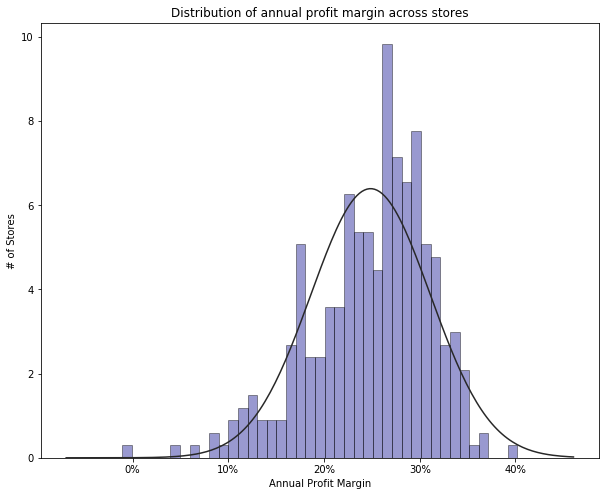

In [14]:
plt.figure(figsize=(10, 8))

ax = sns.distplot(annual_data['profit_margin'], hist=True, kde=False, color = 'darkblue', 
             bins=int((annual_data['profit_margin'].max()-annual_data['profit_margin'].min())/0.01),
             hist_kws={'edgecolor':'black'},fit=stats.norm)

tmp = ax.set(xlabel='Annual Profit Margin', ylabel='# of Stores')
tmp2 = ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
title = plt.title('Distribution of annual profit margin across stores')

- On comparing distribution of profit margin to a normal distributed sample, profit margins don't seem to be normally distributed

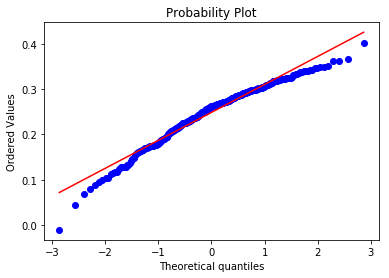

In [15]:
ax2 = plt.plot()
res = stats.probplot(x=annual_data['profit_margin'], plot=plt) 

- From the shape of q-q plot, our profit margin distribution isn't normally distributed, instead the shape suggests we have a longer tail on the left

In [16]:
# Null hypothesis : Profit margins are normally distributed. 
# Result of hypothesis test suggests that null hypothesis can be rejectd

stats.normaltest(annual_data['profit_margin'])

NormaltestResult(statistic=31.74720837715713, pvalue=1.2769717598778455e-07)

- We can see from the normal test that the p value is very low.
- Using an alpha of 0.001 , since p < alpha, we can reject the null hypothesis that the profit margins are normally distributed.

#### 2) Please plot the monthly and quarterly aggregate revenue across all stores

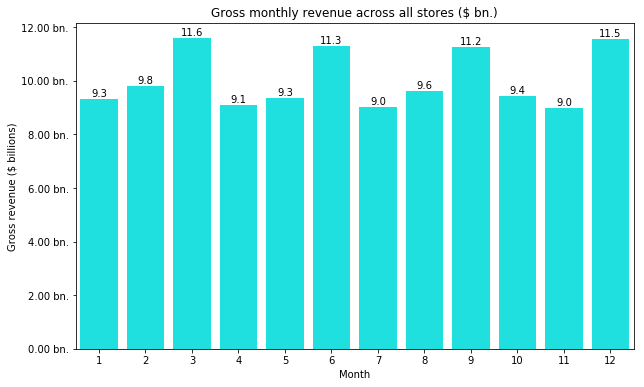

In [17]:
plt.figure(figsize=(10, 6))
m = sns.barplot(x='Month',y='Gross revenue',data=monthly_data,color="cyan")
tmp = m.set(xlabel='Month', ylabel='Gross revenue ($ billions)')
plt.title("Gross monthly revenue across all stores ($ bn.)")

m.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000000000) + ' bn.'))

for index, row in monthly_data.iterrows():
    m.text(row.Month-1,row['Gross revenue']+100000000, round(row['Gross revenue']/1000000000,1), color='black', ha="center")

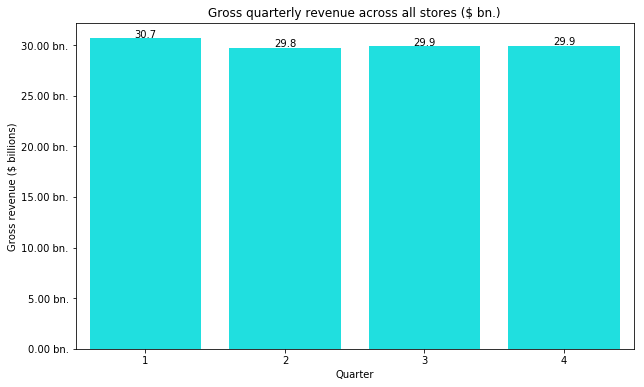

In [18]:
plt.figure(figsize=(10, 6))
q = sns.barplot(x='quarter',y='Gross revenue',data=quarterly_data,color="cyan")
tmp = q.set(xlabel='Quarter', ylabel='Gross revenue ($ billions)')
plt.title("Gross quarterly revenue across all stores ($ bn.)")

q.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000000000) + ' bn.'))

for index, row in quarterly_data.iterrows():
    q.text(row.quarter-1,row['Gross revenue']+100000000, round(row['Gross revenue']/1000000000,1), color='black', ha="center")

### Part 2 - Cleaning the data

In [19]:
# Seeing number of owned vs leased locations
annual_data['Owned'].value_counts()

False    297
True      36
Name: Owned, dtype: int64

In [20]:
# Creating a separate dataframe for only leased locations vs only owned locations to understand what drives rental cost
msk_rented = operating_data_df['Owned']==False
rental_stores_data = operating_data_df[msk_rented]
owned_stores_data = operating_data_df[~msk_rented]

In [21]:
# Collapsing rental and owned stores data separately by location number
# We are adding up monthly revenue, fixed cost, variable costs and rental to get annual numbers

operations_dict = {'State':'min',
                   'Gross revenue':'sum',
                   'Fixed cost':'sum',
                   'Variable cost':'sum',
                   'Rental cost':'sum',
                   'Number of products':'mean', # since number of products is same for a store across months
                   'Owned':'min'}

rental_stores_data_by_store = rental_stores_data.groupby('Location number').agg(operations_dict).reset_index()
owned_stores_data_by_store = owned_stores_data.groupby('Location number').agg(operations_dict).reset_index()

rental_stores_data_by_store.rename(columns={'Gross revenue':'Annual_gross_revenue',
                                            'Fixed cost':'Annual_fixed_cost',
                                            'Variable cost':'Annual_variable_cost',
                                            'Rental cost':'Annual_rental_cost'},inplace=True)
owned_stores_data_by_store.rename(columns={'Gross revenue':'Annual_gross_revenue',
                                            'Fixed cost':'Annual_fixed_cost',
                                            'Variable cost':'Annual_variable_cost',
                                            'Rental cost':'Annual_rental_cost'},inplace=True)

In [22]:
rental_stores_data_by_store.head()

,Location number,State,Annual_gross_revenue,Annual_fixed_cost,Annual_variable_cost,Annual_rental_cost,Number of products,Owned
0,1,TX,544738868.630,110895576.690,279368713.890,4390560,4452,False
1,2,TX,355973012.710,72873948.790,193729099.950,783240,4502,False
2,4,GA,263984311.310,64104092.800,143239809.710,1696920,4481,False
3,5,NJ,189001593.490,44750496.240,103755318.740,894000,4533,False
4,6,IL,117024430.367,31993754.010,65840306.800,393480,4373,False


In [23]:
#Checking correlations of annual rental costs to other variables
rental_stores_data_by_store[['Annual_gross_revenue', 'Annual_fixed_cost',
                             'Annual_variable_cost',  'Number of products', 'Annual_rental_cost']].corr()

,Annual_gross_revenue,Annual_fixed_cost,Annual_variable_cost,Number of products,Annual_rental_cost
Annual_gross_revenue,1.000,0.958,0.992,0.453,0.656
Annual_fixed_cost,0.958,1.000,0.964,0.303,0.695
Annual_variable_cost,0.992,0.964,1.000,0.403,0.657
Number of products,0.453,0.303,0.403,1.000,-0.032
Annual_rental_cost,0.656,0.695,0.657,-0.032,1.000


- We can see from the above correlation matrix that annual rental cost is correlated positively with annual: fixed cost, variable cost and gross revenue, but these three are also highly correlated to each other

In [24]:
# Checking if annual rental costs are correlated to states
pd.get_dummies(rental_stores_data_by_store,prefix='State',columns=['State'])[['Annual_rental_cost']+['State_'+x for x in rental_stores_data_by_store['State'].unique()]].corr()

,Annual_rental_cost,State_TX,State_GA,State_NJ,State_IL,State_CA,State_CO,State_WA
Annual_rental_cost,1.000,0.082,-0.055,0.000,-0.025,-0.015,-0.012,-0.000
State_TX,0.082,1.000,-0.297,-0.217,-0.268,-0.332,-0.141,-0.141
State_GA,-0.055,-0.297,1.000,-0.148,-0.183,-0.226,-0.096,-0.096
State_NJ,0.000,-0.217,-0.148,1.000,-0.134,-0.166,-0.070,-0.070
State_IL,-0.025,-0.268,-0.183,-0.134,1.000,-0.204,-0.087,-0.087
State_CA,-0.015,-0.332,-0.226,-0.166,-0.204,1.000,-0.108,-0.108
State_CO,-0.012,-0.141,-0.096,-0.070,-0.087,-0.108,1.000,-0.046
State_WA,-0.000,-0.141,-0.096,-0.070,-0.087,-0.108,-0.046,1.000


- Rental cost doesn't seem to be strongly correlated to the store being in a particular state vs other

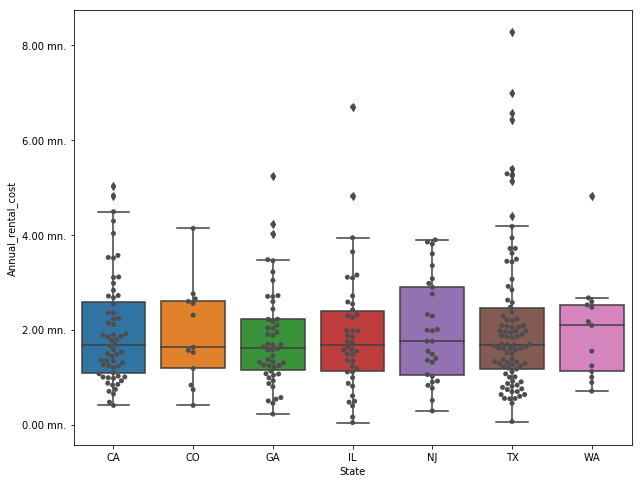

In [25]:
states_sorted = rental_stores_data_by_store['State'].unique().tolist()
states_sorted.sort()

plt.figure(figsize=(10, 8))
ax = sns.boxplot(x='State',y='Annual_rental_cost',data=rental_stores_data_by_store,order = states_sorted)
ax = sns.swarmplot(x='State',y='Annual_rental_cost',data=rental_stores_data_by_store, color=".3",order = states_sorted)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000000) + ' mn.'))

- From the box plots, we can see that the median rental cost across the 7 states is not very different, but within each state, annual rental costs are widely distributed. 
- Hence it wouldn't be accurate to impute a single (median) rental cost for properties in the same state
------------------
- We see a strong positive correlation between rental costs and fixed costs, so we can use this to get an estimate of rental costs for owned stores.

In [26]:
# We can see annual fixed costs have a wide range from $21.3 Mn - $ 231.7 Mn with 50% of values clustered between 54 - 83 Mn
rental_stores_data_by_store['Annual_fixed_cost'].describe()

count         297.000
mean     73244584.915
std      30604079.283
min      21365087.660
25%      54085885.520
50%      66002389.460
75%      83426022.770
max     231706060.340
Name: Annual_fixed_cost, dtype: float64

In [27]:
# Binning rental stores based on fixed cost amounts to observe distribution of rental costs in each bucket

bins = [0,30000000,40000000,50000000,60000000,70000000,80000000,90000000,100000000,150000000,240000000]
rental_stores_data_by_store['annual_fc_bins'] = pd.cut(rental_stores_data_by_store['Annual_fixed_cost'],include_lowest=True,bins = bins)

In [28]:
rental_stores_data_by_store.head()

,Location number,State,Annual_gross_revenue,Annual_fixed_cost,Annual_variable_cost,Annual_rental_cost,Number of products,Owned,annual_fc_bins
0,1,TX,544738868.630,110895576.690,279368713.890,4390560,4452,False,"(100000000.0, 150000000.0]"
1,2,TX,355973012.710,72873948.790,193729099.950,783240,4502,False,"(70000000.0, 80000000.0]"
2,4,GA,263984311.310,64104092.800,143239809.710,1696920,4481,False,"(60000000.0, 70000000.0]"
3,5,NJ,189001593.490,44750496.240,103755318.740,894000,4533,False,"(40000000.0, 50000000.0]"
4,6,IL,117024430.367,31993754.010,65840306.800,393480,4373,False,"(30000000.0, 40000000.0]"


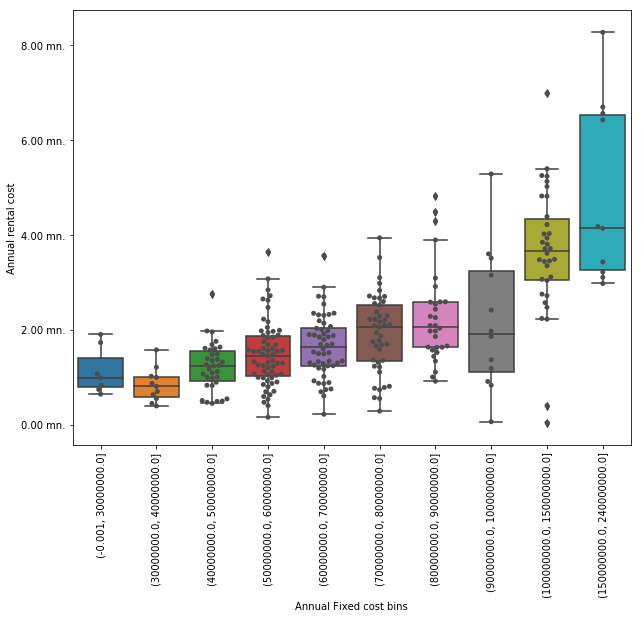

In [29]:
plt.figure(figsize=(10, 8))
ax = sns.boxplot(x='annual_fc_bins',y='Annual_rental_cost',data=rental_stores_data_by_store)
ax = sns.swarmplot(x='annual_fc_bins',y='Annual_rental_cost',data=rental_stores_data_by_store, color=".3")

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000000) + ' mn.'))
ticks = plt.xticks(rotation=90)

tmp = ax.set(xlabel='Annual Fixed cost bins', ylabel='Annual rental cost')

- Now we can observe that stores within the same annual fixed cost bin are less distributed in terms of rental cost. Further we can see an increase in average rental cost with an increase in fixed costs
- However, we have some outliers in the data. We can take of these next.

In [35]:
# Function takes a dataset, efined segmentation column and a metric 
# It groupss data by segmentation column and calculates outliers based on the values of metric within each segment

def identify_outliers(df,segment_by='annual_fc_bins',metric='Annual_rental_cost'):
    grouped = df.groupby(by=[segment_by],axis=0)[metric].describe()[['mean', 'count', '25%', '50%', '75%']]
    grouped.reset_index(inplace=True)
    grouped['iqr']=grouped['75%'] - grouped['25%']
    grouped['upper_whisker'] = grouped['75%']+1.5*grouped['iqr']
    grouped['lower_whisker'] = grouped['25%']-1.5*grouped['iqr']

    df = df.merge(grouped,on=[segment_by],how='left')
    df['outlier']=np.where((df[metric]<df['lower_whisker']) | (df[metric]>df['upper_whisker']),1,0)
    df.drop(columns=['mean','count','25%','50%','75%','iqr','upper_whisker','lower_whisker'],inplace=True)
    
    return df

In [37]:
rental_stores_data_outlier_marked = identify_outliers(rental_stores_data_by_store,segment_by='annual_fc_bins',metric='Annual_rental_cost')

In [38]:
rental_stores_data_outlier_marked.shape

(297, 10)

In [39]:
rental_stores_data_outlier_marked['outlier'].value_counts()

0    288
1      9
Name: outlier, dtype: int64

In [40]:
# Removing outliers for purposes of rental cost imputation
rental_stores_data_outlier_marked = rental_stores_data_outlier_marked[rental_stores_data_outlier_marked['outlier']==0]
rental_stores_data_outlier_marked.shape

(288, 10)

### Now that outliers are removed, we try to build a model to impute the rental cost of owned properties based on the fixed costs of the store

In [43]:
# Function runs a linear regression n number of times choosing a different train and test subset each time
# and returns the calculated Root mean squared errors from each run

def Out_of_sample_RMSE (df, y ,formula, n, pct):
    df_out = []
    a_list = []
    rsq_list = []
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = pct)
        
        y_train = pd.DataFrame(y_train)
        tmp = y_train.merge(X_train)
        
        y_test = pd.DataFrame(y_test)
        tmp_test = y_test.merge(X_test)
        
        reg = ols(formula, data=tmp).fit()
        predictions = reg.predict(tmp_test)
        
        tmp = pd.DataFrame(predictions, columns = ['Predict'])
        msk = list(y_test)
        tmp['Original'] = tmp_test[msk]
        tmp['Sqd. Errors'] = np.square(tmp['Predict']-tmp['Original'])
        
        a_list.append(np.sqrt(tmp['Sqd. Errors'].mean()))
        rsq_list.append(reg.rsquared_adj)
    print(f"Mean adj. R2 across {n} runs:, {sum(rsq_list)/len(rsq_list)}")
    return pd.DataFrame(a_list,columns=['RMSE'])

In [44]:
all_features = ['Annual_fixed_cost']
all_features = "+".join(all_features)
formula2 = "Annual_rental_cost~" + all_features

RMSE = Out_of_sample_RMSE(rental_stores_data_outlier_marked,rental_stores_data_outlier_marked['Annual_rental_cost'] ,formula2 ,100 ,0.25)

Mean adj. R2 across 100 runs:, 0.5475546160370209


In [45]:
print("Mean out-of-sample RMSE of model across all runs: ",RMSE.mean())

Mean out-of-sample RMSE of model across all runs:  RMSE   824037.917
dtype: float64


- We can see that the mean RMSE of the model is high. This is because we only have one strong predictor of rental cost. With additional features available for stores, this estimate can be improved in future iterations.

In [46]:
# Fitting the model using complete rental store dataset

all_columns = ['Annual_fixed_cost']
all_columns = "+".join(all_columns)

#run OLS on all other columns
formula2 = "Annual_rental_cost~" + all_columns
reg2 = ols(formula2, data=rental_stores_data_outlier_marked).fit()
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:     Annual_rental_cost   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     352.4
Date:                Sun, 04 Aug 2019   Prob (F-statistic):           8.63e-52
Time:                        18:23:31   Log-Likelihood:                -4327.3
No. Observations:                 288   AIC:                             8659.
Df Residuals:                     286   BIC:                             8666.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -2.007e+05   1.24e+0

In [47]:
reg2.rsquared_adj

0.5504201392764414

#### Now we use this model to impute rental cost for owned stores

In [48]:
owned_stores_data_by_store['imputed_rental_cost']=reg2.predict(owned_stores_data_by_store)

In [49]:
owned_stores_data_by_store = owned_stores_data_by_store[['Location number','imputed_rental_cost']]

In [50]:
owned_stores_data_by_store['imputed_rental_cost'] = owned_stores_data_by_store['imputed_rental_cost']/12
owned_stores_data_by_store.rename(columns={'imputed_rental_cost':'imputed_monthly_rental_cost'},inplace=True)

In [51]:
owned_stores_data_by_store.head()

,Location number,imputed_monthly_rental_cost
0,3,140910.828
1,9,327281.737
2,11,141464.836
3,21,142592.779
4,31,138370.130


In [52]:
operating_data_df = operating_data_df.merge(owned_stores_data_by_store,on='Location number',how='left')

In [53]:
msk = operating_data_df['imputed_monthly_rental_cost'].isna()
operating_data_df.loc[msk,'imputed_monthly_rental_cost'] = operating_data_df.loc[msk,'Rental cost']

In [54]:
operating_data_df.head(10)

,Location number,Month,State,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned,quarter,imputed_monthly_rental_cost
0,1,1,TX,48628171.020,9218156.690,24278189.230,365880,4452,False,1,365880.000
1,1,2,TX,48107179.240,10587747.350,25116844.410,365880,4452,False,1,365880.000
2,1,3,TX,64352278.290,10193873.770,33703499.830,365880,4452,False,1,365880.000
3,1,4,TX,45943677.960,8764165.000,24037719.470,365880,4452,False,2,365880.000
4,1,5,TX,32761434.980,8022116.430,16432119.180,365880,4452,False,2,365880.000
5,1,6,TX,50677036.260,9763597.300,26233794.370,365880,4452,False,2,365880.000
6,1,7,TX,28215465.220,8245679.540,14457234.120,365880,4452,False,3,365880.000
7,1,8,TX,38955413.840,7863853.690,19744464.290,365880,4452,False,3,365880.000
8,1,9,TX,43602895.190,9067861.360,22138203.510,365880,4452,False,3,365880.000
9,1,10,TX,52406102.980,9062239.730,26246199.300,365880,4452,False,4,365880.000


In [55]:
operations_dict = {'State':'min',
                   'Gross revenue':'sum',
                   'Fixed cost':'sum',
                   'Variable cost':'sum',
                   'imputed_monthly_rental_cost':'sum',
                   'Number of products':'mean',
                   'Owned':'min'}

annual_data_w_imputed_rent = operating_data_df.groupby('Location number').agg(operations_dict).reset_index()
annual_data_w_imputed_rent.shape

(333, 8)

In [56]:
annual_data_w_imputed_rent['total_cost'] =annual_data_w_imputed_rent[[x for x in annual_data_w_imputed_rent.columns if 'cost' in x]].sum(axis=1) 
annual_data_w_imputed_rent['profit'] = annual_data_w_imputed_rent['Gross revenue'] - annual_data_w_imputed_rent['total_cost']
annual_data_w_imputed_rent['profit_margin'] = annual_data_w_imputed_rent['profit'] / annual_data_w_imputed_rent['Gross revenue']

In [57]:
mean_profit_margin_adj = annual_data_w_imputed_rent['profit_margin'].mean()
print("_______________________________________________________________________________")
print(f"\nMean rent-adjusted annual profit margin of a typical store is --> {mean_profit_margin_adj*100:.2f} %")
print("_______________________________________________________________________________")

_______________________________________________________________________________

Mean rent-adjusted annual profit margin of a typical store is --> 24.81 %
_______________________________________________________________________________


In [58]:
median_profit_margin_adj = annual_data_w_imputed_rent['profit_margin'].median()
print("_______________________________________________________________________________")
print(f"Median rent-adjusted annual profit margin of a typical store is --> {median_profit_margin_adj*100:.2f} %")
print("_______________________________________________________________________________")

_______________________________________________________________________________
Median rent-adjusted annual profit margin of a typical store is --> 26.09 %
_______________________________________________________________________________


In [59]:
annual_data_w_imputed_rent.groupby('Owned').agg({'profit_margin':'mean'})

,profit_margin
Owned,
False,0.244
True,0.281


- From the above breakdown we can see that before imputing a rental cost for owned properties, the mean profit margin of owned properties was 28.6 % . After imputing rental cost, the new average profit margin for owned properties drops to 28.1% which is a more accurate value to compare against the profit margins for leased stores.

In [145]:
operating_data_df.to_csv('operating_data_with_imputed_rent.csv')
annual_data_w_imputed_rent.to_csv('annual_data_with_imputed_rent.csv')

### The output data with imputed rental rates is used as input to a Tableau model to generate insights on drivers of profit margin and create terse visuals for powerpoints